In [20]:
from fastchat.llm_judge.common import load_questions, load_model_answers

#medusa_path = 'llm_judge/data/mt_bench/model_answer/medusa_vicuna-7b-v1.3_medusa_5-temperature-0.0-posterior_threshold-0.09-posterior_alpha-0.3-top_p-0.8-sampling-typical-fast-False.jsonl'
#medusa_path = 'llm_judge/data/mt_bench/model_answer/official_medusa_vicuna-7b-v1.3_medusa_5-temperature-0.0-posterior_threshold-0.09-posterior_alpha-0.3-top_p-0.8-sampling-typical-fast-False.jsonl'
medusa_path = 'eagle/data/mt_bench/model_answer/eagle-2_vicuna-7b-v1.3-temperature-1.0.jsonl'
base_path = 'eagle/data/mt_bench/model_answer/baseline_vicuna-7b-v1.3-temperature-1.0.jsonl'
ques_path = 'eagle/data/mt_bench/question.jsonl'

In [21]:
medusa_ans = load_questions(medusa_path, None, None)
base_ans = load_questions(base_path, None, None)
ques = load_questions(ques_path, None, None)

In [22]:
def gather_attr(ans: list, attr: str):
    '''
    Gather attr from a list of json object

    Args:
    - ans: answer list
    - attr: attributes of json object, including idxs, new_tokens, wall_time

    Return:
    - a list of target attributes
    '''
    attrs = []
    for item in ans:
        attrs.append(sum(item['choices'][0][attr]))
    return attrs

In [23]:
bench_dict = {'id': [item['question_id'] for item in ques], 'category': [item['category'] for item in ques]}
colomn = ['idxs', 'new_tokens', 'wall_time']
for key in colomn:
    bench_dict['medusa_'+key] = gather_attr(medusa_ans, key)
for key in colomn:
    bench_dict['base_'+key] = gather_attr(base_ans, key)

In [24]:
import pandas as pd

bench_data = pd.DataFrame(bench_dict)
bench_data

,id,category,medusa_idxs,medusa_new_tokens,medusa_wall_time,base_idxs,base_new_tokens,base_wall_time
0,81,writing,205,722,6.680902,1206,1208,33.102403
1,82,writing,81,395,2.723498,491,493,13.472281
2,83,writing,83,323,2.784691,255,257,7.121338
3,84,writing,198,845,6.475414,835,837,22.260955
4,85,writing,131,426,4.291843,624,626,16.581606
...,...,...,...,...,...,...,...,...
75,156,humanities,295,960,9.530230,995,997,26.267545
76,157,humanities,212,837,6.916083,902,904,23.861461
77,158,humanities,233,908,7.517942,600,602,15.853966
78,159,humanities,234,858,7.550693,1048,1050,28.334778


In [25]:
medusa_speed = bench_data['medusa_new_tokens'].sum()/bench_data['medusa_wall_time'].sum()
base_speed = bench_data['base_new_tokens'].sum()/bench_data['base_wall_time'].sum()
compress_ratio = bench_data['medusa_new_tokens'].sum()/bench_data['medusa_idxs'].sum()

print(f'Medusa model: {medusa_speed} tokens/s, Base model: {base_speed} tokens/s \n Compression ratio: {compress_ratio}, Accelerate: {medusa_speed/base_speed}')

Medusa model: 126.41085019060522 tokens/s, Base model: 37.175484644251725 tokens/s 
 Compression ratio: 4.165750915750916, Accelerate: 3.400382036718156


In [26]:
cat_data = bench_data.groupby('category')
cat_medusa = cat_data['medusa_new_tokens'].sum()/cat_data['medusa_wall_time'].sum()
cat_base = cat_data['base_new_tokens'].sum()/cat_data['base_wall_time'].sum()

In [27]:
speed_up = (cat_medusa/cat_base).sort_values()
speed_up

category
humanities    3.089252
roleplay      3.132873
writing       3.135139
reasoning     3.218965
stem          3.385429
extraction    3.846062
math          3.859317
coding        3.881903
dtype: float64

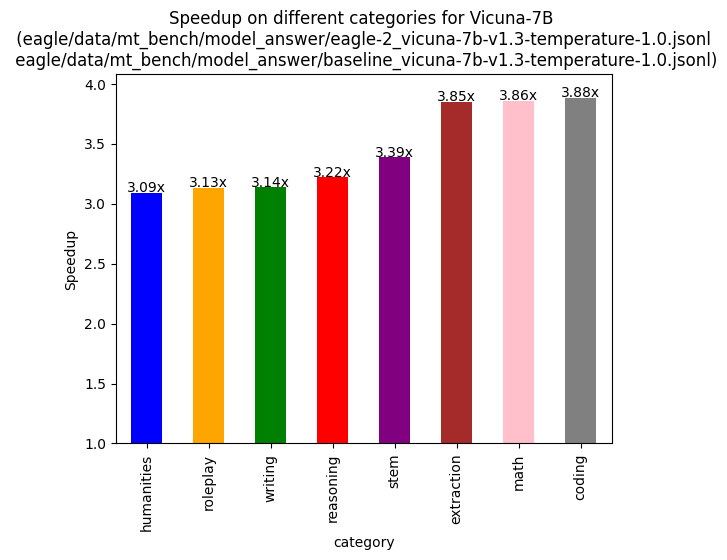

In [28]:
import matplotlib.pyplot as plt

speed_up.plot.bar(bottom = 0, color=['blue','orange','green','red','purple','brown','pink','grey'])
for i, value in enumerate(speed_up):     
    plt.text(i, value+0.1, str('%.2fx'%value), ha='center', va='top')
plt.ylim((1.0, speed_up.max()+0.2))
plt.xlabel('category')
plt.ylabel('Speedup')
plt.title(f'Speedup on different categories for Vicuna-7B \n ({medusa_path} \n {base_path})')
plt.show()